问题：如何使用jax完成简单的线性回归


为什么bias的估计值和真实值相差甚远？**暂时无解，但使用jaxopt的optimizer就可以得到更准确的估计**。

In [1]:
# 导入jax相关包
import jax
import jax.numpy as jnp
from jax import random, grad, jit
from jaxopt import GradientDescent
import matplotlib.pyplot as plt

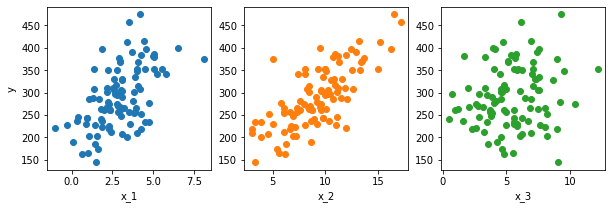

In [2]:
# 生成一组100x2的服从正态分布的随机数，100个观测值，2个features，均值分别为3和9，标准差分别为1.5和3.0
x = random.normal(key=random.PRNGKey(1), shape=(100, 3)) * jnp.array([1.5, 3., 2]) + jnp.array([3., 9., 5.4])
# 真实的weights和bias
w_true = jnp.array([30., 19., 2.3])
b_true = jnp.array([15.])
# 均值为0，标准差为1.5的error/noise distribution
noise = random.normal(key=random.PRNGKey(2), shape=(100,)) * 1.3

# 一般线性回归关系
y = x @ w_true + b_true + noise

# 可视化
_, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].scatter(x[:,0], y, color="C0")
ax[0].set_xlabel("x_1")
ax[0].set_ylabel("y")

ax[1].scatter(x[:,1], y, color="C1")
ax[1].set_xlabel("x_2")


ax[2].scatter(x[:,2], y, color="C2")
ax[2].set_xlabel("x_3")

plt.show()

In [124]:
# 定义MSE计算方程 (loss function) 
# define mean squared error MSE function to calculate loss
def loss(w, b, x, y):
    pred = x.dot(w) + b
    return jnp.mean((pred - y)**2)

# 测试loss function
loss(w_true, b_true, x, y)

DeviceArray(1.4159079, dtype=float32)

In [125]:
# 定义gradient function
grad_w = jit(grad(loss, argnums=0))
grad_b = jit(grad(loss, argnums=1))

In [126]:
# 初始化w_est和b_est
w_est = random.normal(key=random.PRNGKey(123), shape=(3,))
b_est = random.normal(key=random.PRNGKey(123), shape=(1,))
print(f"Initiialization:\nw_est: {w_est}\nb_est: {b_est}")

# 梯度下降求解回归方程解
n_iter = 15000  # 梯度下降次数
learning_rate = 1e-4 # 参数更新步长
for i in range(n_iter):
    dw = grad_w(w_est, b_est, x, y) # 求w的梯度
    db = grad_b(w_est, b_est, x, y) # 求b的梯度
    l = loss(w_est, b_est, x, y)    # 求当前w,b下的loss
    if i%(n_iter/10) == 0:
        print(f"Epoch: {i} | Loss: {l}")
    w_est -= dw * learning_rate     # 更新w_est和b_est
    b_est -= db * learning_rate

print(f"w_true: {w_true} | w_estimates: {w_est}\nb_true: {b_true} | b_estimate: {b_est}")

Initiialization:
w_est: [-0.1470326  0.5524756  1.648498 ]
b_est: [-0.75307846]
Epoch: 0 | Loss: 80997.0234375
Epoch: 1500 | Loss: 431.9439697265625
Epoch: 3000 | Loss: 111.64945220947266
Epoch: 4500 | Loss: 33.90357208251953
Epoch: 6000 | Loss: 14.90784740447998
Epoch: 7500 | Loss: 10.146549224853516
Epoch: 9000 | Loss: 8.837448120117188
Epoch: 10500 | Loss: 8.36886215209961
Epoch: 12000 | Loss: 8.108123779296875
Epoch: 13500 | Loss: 7.90197229385376
w_true: [30.  19.   2.3] | w_estimates: [30.818356 19.587809  2.74294 ]
b_true: [15.] | b_estimate: [4.2647114]


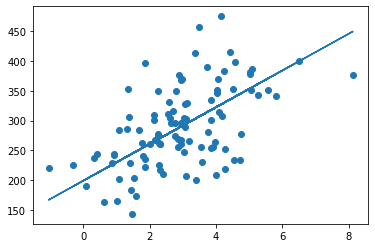

In [135]:
plt.scatter(x[:,0], y)
plt.plot(x[:,0], x[:,0]*w_est[0]+b_est+x[:,1].mean()*w_est[1]+x[:,2].mean()*w_est[2])

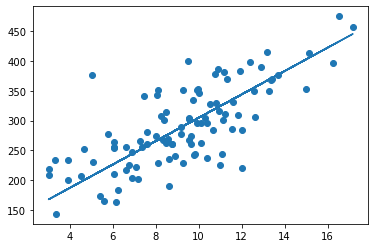

In [136]:
plt.scatter(x[:,1], y)
plt.plot(x[:,1], x[:,1]*w_est[1]+b_est+x[:,0].mean()*w_est[0]+x[:,2].mean()*w_est[2])

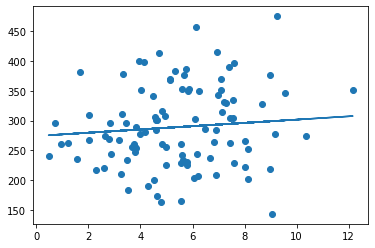

In [137]:
plt.scatter(x[:,2], y)
plt.plot(x[:,2], x[:,2]*w_est[2]+b_est+x[:,1].mean()*w_est[1]+x[:,0].mean()*w_est[0])

## customed optimizer

In [127]:
params = {
    "w": jnp.zeros(x.shape[1:]),
    "b": 0.
}

def forward(params, x):
    return jnp.dot(x, params["w"]) + params["b"]


def loss_fn(params, x, y):
    err = forward(params, x) - y
    return jnp.mean(jnp.square(err))

grad_fn = jit(grad(loss_fn))

@jit
def update(params, grads, lr=1e-3):
    return jax.tree_map(lambda p, g: p - lr * g, params, grads)

epoch = 5000
losses = []
for i in range(epoch):
    loss = loss_fn(params, x, y)
    losses.append(loss)
    if i % (epoch/10) ==0:
        print(loss)
    
    grads = grad_fn(params, x, y)
    params = update(params, grads)

print(params)

88454.555
22.45674
7.616461
6.9317517
6.421828
5.959433
5.5392933
5.1574597
4.8104825
4.49523
{'b': DeviceArray(8.050766, dtype=float32, weak_type=True), 'w': DeviceArray([30.578608 , 19.378103 ,  2.5620208], dtype=float32)}


/var/folders/cb/pxnfxyts32n8rdq49q4djgs80000gn/T/ipykernel_18580/1188321443.py:18: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  return jax.tree_map(lambda p, g: p - lr * g, params, grads)


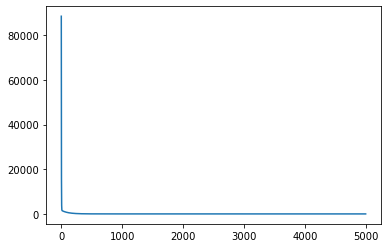

In [128]:
plt.plot(jnp.arange(0,epoch), jnp.array(losses))

## jaxopt optimizer

In [8]:
params = {
    "w": jnp.zeros(x.shape[1:]),
    "b": 0.
}

def forward(params, x):
    return jnp.dot(x, params["w"]) + params["b"]


def loss_fn(params, x, y):
    err = forward(params, x) - y
    return jnp.mean(jnp.square(err))

solver = GradientDescent(loss_fn)
res = solver.run(params, x, y)
res.params, res.state

({'b': DeviceArray(15.972321, dtype=float32),
  'w': DeviceArray([30.033394 , 18.941668 ,  2.2022767], dtype=float32)},
 ProxGradState(iter_num=DeviceArray(500, dtype=int32, weak_type=True), stepsize=DeviceArray(0.015625, dtype=float32), error=DeviceArray(0.49452642, dtype=float32), aux=None, velocity={'b': DeviceArray(15.964679, dtype=float32), 'w': DeviceArray([30.03392  , 18.942108 ,  2.2026358], dtype=float32)}, t=DeviceArray(252.37917, dtype=float32, weak_type=True)))